In [1]:
import pandas as pd
import pyBigWig
import actc_seq
import numpy as np
import seaborn as sns
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from collections import Counter
from pylab import rcParams
from itertools import product


In [6]:
# ess gene
ess_noness = pd.read_csv('../../Data/PrimaryLibrary/design/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv')
EssGene = ess_noness[ess_noness.Category == 'Essential']['Target Gene Symbol'].unique()
# atac
atac_path = '../../Data/ATACseq/'
chrtest = pd.read_csv(atac_path+'ATACseqPeakOverlap_v2.csv')
# NewDatasetCombine
inpath = '../../Data/CleanedExternalData/'
NewDatasetCombine = pd.read_csv(inpath+'DatasetCombineCleaned_v3.csv', low_memory=False)


In [7]:
#keeping essential genes from in house dataset (Defined by Hart et al)
InhouseEssAtac = chrtest[(chrtest.DataSet == 'InHouse') & (chrtest['Target Gene Symbol'].isin(EssGene))]
otherAtac = chrtest[~(chrtest.DataSet == 'InHouse')]
newATAC = pd.concat([InhouseEssAtac,otherAtac])

In [8]:
newATAC[newATAC.DataSet == 'InHouse']['Target Gene Symbol'].value_counts()
# Remove genes with any overlapped in categories 2 or 3
# non_overlapping_library_23_select_ess_noness_drop_dup.csv
# Essential genes: 144
# Non-essential genes: 189


TEDC1     14399
MROH6     14119
YY1       13895
DNLZ      13853
WEE1      13440
          ...  
RFC3       5054
MRPL45     4879
MTPAP      4879
MRPS10     4081
LARS1      3997
Name: Target Gene Symbol, Length: 144, dtype: int64

In [9]:
def perform_mannwhitney_tests(chrtest, gene_col, phenotype):
    results = []
    # Get unique values from the specified columns
    ATACseq = chrtest['ATACseq'].unique()
    DataSet = chrtest['DataSet'].unique()
    Domain = chrtest['Domain'].unique()
    condition = chrtest['condition'].unique()

    # Iterate over the combinations of parameters
    for atac in tqdm(ATACseq):
        
        for data in tqdm(DataSet):
            if data == 'InHouse':
                alter = 'greater'
            elif data == 'Nunez':
                alter = 'greater'
            elif data == 'Gilbert':
                alter = 'less'
            for krab in tqdm(Domain):
                for cell in tqdm(condition):
                    chrtest_subset = chrtest[(chrtest['ATACseq'] == atac) & (chrtest['Domain'] == krab) & 
                                             (chrtest['DataSet'] == data) & (chrtest['condition'] == cell)]
                    for gene in chrtest_subset[gene_col].unique():
                        gene_sp = chrtest_subset[chrtest_subset[gene_col] == gene]
                        binary_col = 'overlap with peak'
                        if (sum(gene_sp[binary_col] == 1) >= 10) & (sum(gene_sp[binary_col] == 0) >= 10):
                            _, pval = mannwhitneyu(gene_sp[gene_sp[binary_col] == 0][phenotype], 
                                                   gene_sp[gene_sp[binary_col] == 1][phenotype], 
                                                   alternative=alter, method="asymptotic")
                            results.append({
                                'ATACseq': atac,
                                'DataSet': data,
                                'Domain': krab,
                                'condition': cell,
                                'gene': gene,
                                'pval': pval
                            })
                        else:
                            print(f"{gene}: Sample size in overlap or non-overlap < 10")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df


In [10]:
results_df = perform_mannwhitney_tests(newATAC, 'Target Gene Symbol', 'orginal phenotype')


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

KDSR: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:01,  1.05it/s]

KDSR: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:00,  1.02it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.34s/it]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

KDSR: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:01,  1.06it/s]

KDSR: Sample size in overlap or non-overlap < 10
BRIX1: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:00,  1.07it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.29s/it]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:04<00:09,  4.58s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


  0%|                                                      

CARF: Sample size in overlap or non-overlap < 10
COPB2: Sample size in overlap or non-overlap < 10
CWF19L2: Sample size in overlap or non-overlap < 10
DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
EIF3A: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
FBL: Sample size in overlap or non-overlap < 10
LEO1: Sample size in overlap or non-overlap < 10
MDN1: Sample size in overlap or non-overlap < 10
MED18: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
MYBL2: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
POLR1B: Sample size in overlap or non-overlap < 10
SCFD1: Sample size in overlap or non-overlap < 10
SNW1: Sample size in overlap or non-overlap < 10
STAT5B: Sample size in overlap or non-overlap < 10
SUPV3L1: Sample size in overlap or non-overlap < 10





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.84s/it]

VPS54: Sample size in overlap or non-overlap < 10





  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]


 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:00,  2.68it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:00<00:00,  2.67it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.67it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.99s/it]

 67%|█████████████████████████████████████████████████████

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:01,  1.05it/s]

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:00,  1.02it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.33s/it]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:01,  1.12it/s]

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:00,  1.10it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.37it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.26s/it]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:04<00:09,  4.52s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


  0%|                                                      

DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
FDPS: Sample size in overlap or non-overlap < 10
LEO1: Sample size in overlap or non-overlap < 10
MRPL35: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
SNRNP35: Sample size in overlap or non-overlap < 10
SNW1: Sample size in overlap or non-overlap < 10





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.67s/it]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]


 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:00,  2.78it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:00<00:00,  2.78it/s]


100%|████████████████████████████████████████████████████

SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:01,  1.11it/s]

DYNLRB1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:00,  1.03it/s]

DYNLRB1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.30it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.31s/it]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:02,  1.02s/it]

DYNLRB1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10
SRSF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
OGT: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:00,  1.03it/s]

DYNLRB1: Sample size in overlap or non-overlap < 10
VPS28: Sample size in overlap or non-overlap < 10





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.29it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.32s/it]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:04<00:09,  4.64s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]


 33%|██████████████████████████████████████████████████    

ATXN10: Sample size in overlap or non-overlap < 10
CARF: Sample size in overlap or non-overlap < 10
CLTC: Sample size in overlap or non-overlap < 10
DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
DNTTIP2: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
LEO1: Sample size in overlap or non-overlap < 10
LSM2: Sample size in overlap or non-overlap < 10
MCM6: Sample size in overlap or non-overlap < 10
MDN1: Sample size in overlap or non-overlap < 10
MIS18BP1: Sample size in overlap or non-overlap < 10
MRPS25: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
MYBL2: Sample size in overlap or non-overlap < 10
NBAS: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
NOP58: Sample size in overlap or non-overlap < 10
POLG2: Sample size in overlap or non-overlap < 10
PO




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.70s/it]

ZCCHC9: Sample size in overlap or non-overlap < 10





  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]


 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:00,  2.78it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:00<00:00,  2.77it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.74it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.90s/it]

 67%|█████████████████████████████████████████████████████

CEBPE: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:01,  1.06it/s]

MROH6: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:00,  1.01it/s]

MROH6: Sample size in overlap or non-overlap < 10





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.36s/it]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

CEBPE: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:01,  1.03it/s]

MROH6: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:00,  1.00it/s]

MROH6: Sample size in overlap or non-overlap < 10





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.37s/it]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:04<00:09,  4.73s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]


 33%|██████████████████████████████████████████████████    

DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
SNRNP35: Sample size in overlap or non-overlap < 10
SNW1: Sample size in overlap or non-overlap < 10





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.89s/it]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]


 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:00,  2.69it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:00<00:00,  2.70it/s]


100%|████████████████████████████████████████████████████

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:01<00:02,  1.00s/it]

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:02<00:01,  1.02s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.42s/it]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:01,  1.00it/s]

KDSR: Sample size in overlap or non-overlap < 10
CEBPE: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:01,  1.00s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.41s/it]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:04<00:09,  4.82s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


  0%|                                                      

DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
STAT5B: Sample size in overlap or non-overlap < 10





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.94s/it]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]


 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:00,  2.64it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:00<00:00,  2.62it/s]


100%|████████████████████████████████████████████████████

CARF: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
LEO1: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.65s/it]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]


 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:00,  2.75it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:00<00:00,  2.71it/s]


100%|████████████████████████████████████████████████████

KDSR: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:01,  1.08it/s]

UPF2: Sample size in overlap or non-overlap < 10


KDSR: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10
UPF2: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:00,  1.08it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:02<00:02,  2.23s/it]


  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]

KDSR: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10





 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:01,  1.08it/s]

UPF2: Sample size in overlap or non-overlap < 10
KDSR: Sample size in overlap or non-overlap < 10
ATIC: Sample size in overlap or non-overlap < 10
UPF2: Sample size in overlap or non-overlap < 10





 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:01<00:00,  1.08it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.34it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.23s/it]

 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:04<00:08,  4.47s/it]

  0%|                                                                                                                                                              | 0/2 [00:00<?, ?it/s]


  0%|                                                      

CARF: Sample size in overlap or non-overlap < 10
COG8: Sample size in overlap or non-overlap < 10
CRNKL1: Sample size in overlap or non-overlap < 10
DBR1: Sample size in overlap or non-overlap < 10
DDX21: Sample size in overlap or non-overlap < 10
EIF3M: Sample size in overlap or non-overlap < 10
LEO1: Sample size in overlap or non-overlap < 10
MDN1: Sample size in overlap or non-overlap < 10
MRPS35: Sample size in overlap or non-overlap < 10
MYBL2: Sample size in overlap or non-overlap < 10
NIP7: Sample size in overlap or non-overlap < 10
NLE1: Sample size in overlap or non-overlap < 10
POLR1B: Sample size in overlap or non-overlap < 10
RAD51: Sample size in overlap or non-overlap < 10
RPF2: Sample size in overlap or non-overlap < 10
SLC35A1: Sample size in overlap or non-overlap < 10
SNRNP35: Sample size in overlap or non-overlap < 10
SNW1: Sample size in overlap or non-overlap < 10
STAT5B: Sample size in overlap or non-overlap < 10





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.01s/it]


 50%|███████████████████████████████████████████████████████████████████████████                                                                           | 1/2 [00:03<00:03,  3.03s/it]

UTP6: Sample size in overlap or non-overlap < 10





  0%|                                                                                                                                                              | 0/3 [00:00<?, ?it/s]


 33%|██████████████████████████████████████████████████                                                                                                    | 1/3 [00:00<00:00,  2.58it/s]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 2/3 [00:00<00:00,  2.66it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.12s/it]

 67%|█████████████████████████████████████████████████████

In [11]:
results_df

,ATACseq,DataSet,Domain,condition,gene,pval
0,K562,InHouse,Kox1,A549,LARS2,2.548750e-02
1,K562,InHouse,Kox1,A549,COQ2,6.601363e-01
2,K562,InHouse,Kox1,A549,IGBP1,4.528819e-03
3,K562,InHouse,Kox1,A549,YEATS4,7.464827e-04
4,K562,InHouse,Kox1,A549,COPS3,2.082482e-05
...,...,...,...,...,...,...
6446,GM12878,Gilbert,Kox1,K562,TUBA1B,4.366963e-03
6447,GM12878,Gilbert,Kox1,K562,UGP2,3.477672e-05
6448,GM12878,Gilbert,Kox1,K562,VPS53,6.881722e-07
6449,GM12878,Gilbert,Kox1,K562,VPS54,1.877460e-22


In [12]:
out_path = '../../Data/ATACseq/Pval/'

results_df.to_csv(out_path+'ATAC_Pval.csv', index = False)

In [13]:
import pandas as pd
out_path = '../../Data/ATACseq/Pval/'

results_df = pd.read_csv(out_path+'ATAC_Pval.csv')
results_df[results_df.gene == 'LARS2']


,ATACseq,DataSet,Domain,condition,gene,pval
0,K562,InHouse,Kox1,A549,LARS2,2.548750e-02
226,K562,InHouse,Kox1,HCT116,LARS2,1.971485e-04
280,K562,InHouse,Zim3,A549,LARS2,1.991787e-02
420,K562,InHouse,Zim3,HCT116,LARS2,1.308905e-02
911,HCT116,InHouse,Kox1,A549,LARS2,3.265259e-02
1139,HCT116,InHouse,Kox1,HCT116,LARS2,2.414924e-04
1193,HCT116,InHouse,Zim3,A549,LARS2,1.746423e-02
1334,HCT116,InHouse,Zim3,HCT116,LARS2,3.811565e-02
1837,A549,InHouse,Kox1,A549,LARS2,1.819333e-02
2057,A549,InHouse,Kox1,HCT116,LARS2,1.838015e-05


In [14]:
# atac
# ess gene
ess_noness = pd.read_csv('../../Data/PrimaryLibrary/design/essentials_nonessentials_CRISPRi_tiling_designs_v2.csv')
EssGene = ess_noness[ess_noness.Category == 'Essential']['Target Gene Symbol'].unique()
# atac
atac_path = '../../Data/ATACseq/'
chrtest = pd.read_csv(atac_path+'ATACseqPeakOverlap_v2.csv')

InhouseEssAtac = chrtest[(chrtest.DataSet == 'InHouse') & (chrtest['Target Gene Symbol'].isin(EssGene))]
otherAtac = chrtest[~(chrtest.DataSet == 'InHouse')]
newATAC = pd.concat([InhouseEssAtac,otherAtac])

In [15]:
single_genes = newATAC[(newATAC['Target Gene Symbol'].isin(['LARS2'])) &
      (newATAC['condition'] == 'A549') & (newATAC['ATACseq'] == 'A549') &
      (newATAC['Domain'] == 'Kox1') & (newATAC['DataSet'] == 'InHouse')].copy()

Text(0, 0.5, 'Phenotype Value')

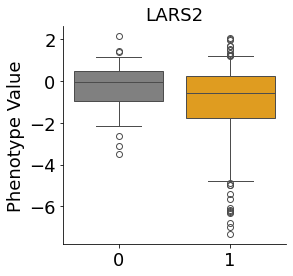

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(4, 4))
sns.boxplot(single_genes,
            x = 'overlap with peak', y='orginal phenotype', hue='overlap with peak', 
                        palette=['grey','orange'], legend=False , whis = [5,95])
sns.despine()
plt.title('LARS2', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('')
plt.ylabel('Phenotype Value',fontsize=18)